# Analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

from visualization import *
from load import *

metrics = load_metrics('../results/metrics.csv')
metrics = preprocessing_metrics(metrics)

print_audit(perform_audit(metrics, RULES))

metrics.head()

-----------------------------------------------REPORT-----------------------------------------------
+ SUCCESS: train_count_is_greater_than_or_equal_to_test_count
+ SUCCESS: jobs_stages_and_tasks_are_sequential
+ SUCCESS: tasks_are_successful
- FAILURE: all_nodes_are_used
- FAILURE: minimum_f1_score_is_respected
- FAILURE: minimum_r2_score_is_respected
- FAILURE: minimum_number_of_algorithms_per_family_is_respected
- FAILURE: minimum_number_of_algorithms_per_dataset_is_respected
- FAILURE: minimum_number_of_datasets_per_algorithm_is_respected
- FAILURE: number_of_nodes_is_respected
+ SUCCESS: maximum_number_of_executors_per_node_is_respected
+ SUCCESS: records_written_is_equivalent_to_bytes_written
+ SUCCESS: records_read_is_equivalent_to_bytes_read
- FAILURE: applicative_time_is_greater_than_or_equal_to_sum_durations_divided_by_number_executors
+ SUCCESS: duration_is_greater_than_or_equal_to_the_sum_of_executor_cpu_deserialize_and_gc_time
+ SUCCESS: tasks_writing_for_shuffle_are_proce

,jobId,jobGroup,stageId,taskId,launchTime,finishTime,duration,schedulerDelay,executorId,host,...,family,runId,silhouette,f1,accuracy,weightedRecall,weightedPrecision,executorCpuUsage,executorDeserializeCpuUsage,shuffleWriteRate
0,4,NaN,6,43,1551697242585,1551697242823,238,5,3,172.16.48.12,...,regression,1,NaN,NaN,NaN,NaN,NaN,0.955882,0.939394,NaN
1,5,NaN,7,44,1551697243024,1551697243275,251,8,1,172.16.48.4,...,regression,1,NaN,NaN,NaN,NaN,NaN,0.578947,0.856287,NaN
2,5,NaN,7,45,1551697243025,1551697243262,237,7,0,172.16.48.8,...,regression,1,NaN,NaN,NaN,NaN,NaN,0.716418,0.877301,NaN
3,5,NaN,7,46,1551697243025,1551697243251,226,7,4,172.16.48.1,...,regression,1,NaN,NaN,NaN,NaN,NaN,0.629032,0.828025,NaN
4,5,NaN,7,47,1551697243025,1551697243272,247,8,2,172.16.48.7,...,regression,1,NaN,NaN,NaN,NaN,NaN,0.328358,0.930233,NaN


### Correlation Analysis

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


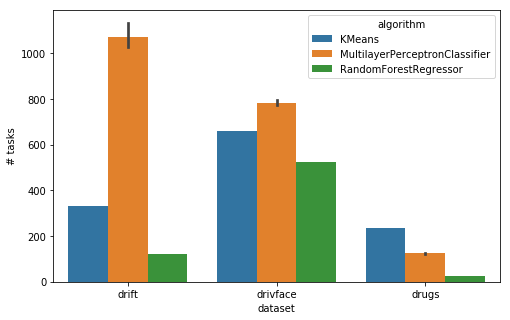

In [29]:
data = spark.groupby(['dataset', 'algorithm', 'runId']).agg({'taskId': 'count'}).rename(columns={'taskId': '# tasks'})

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='# tasks', hue='algorithm', data=data.reset_index())

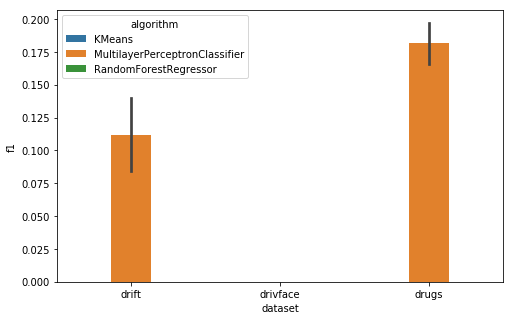

In [127]:
data = full.groupby(level=['dataset', 'algorithm', 'runId']).agg({'f1': 'first', 'r2': 'first', 'silhouette': 'first'})

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='f1', hue='algorithm', data=data.reset_index())

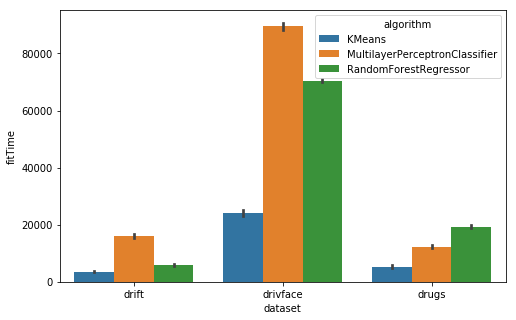

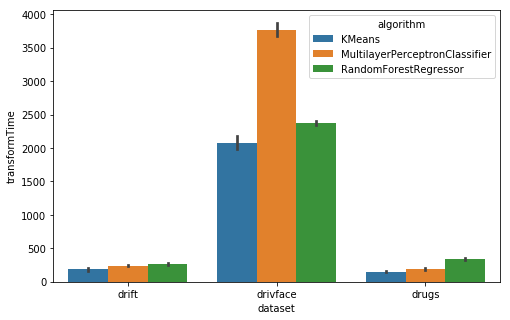

In [114]:
data = full.groupby(level=['dataset', 'algorithm', 'runId']).agg({'fitTime': 'first', 'transformTime': 'first'})

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='fitTime', hue='algorithm', data=data.reset_index())

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='transformTime', hue='algorithm', data=data.reset_index())

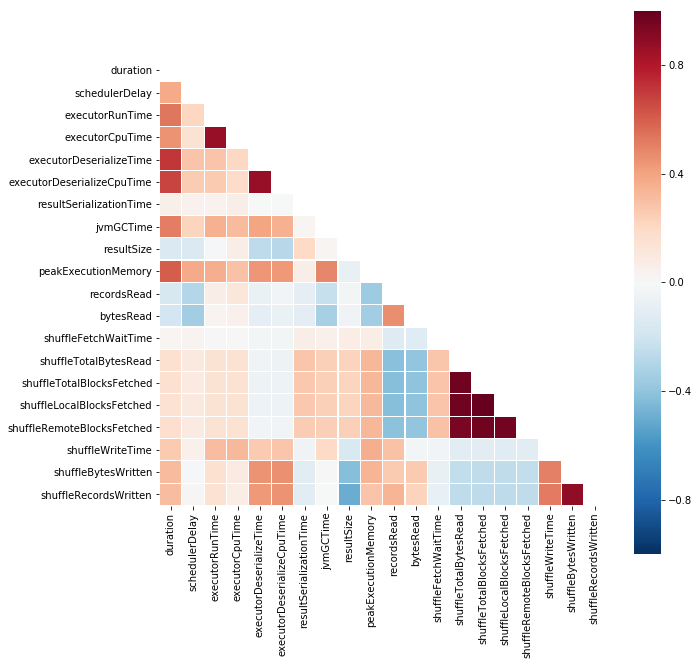

In [30]:
data = spark.corr(method='kendall')

mask = np.zeros_like(data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(mask=mask, cmap="RdBu_r", vmax=1, center=0, vmin=-1, linewidths=0.1, square=True, data=data)

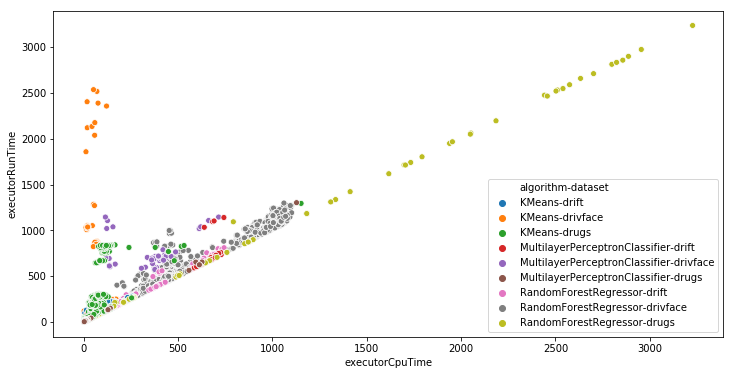

In [590]:
data = stick(spark, 'algorithm', 'dataset')

plt.figure(figsize=(12, 6))
sns.scatterplot(x='executorCpuTime', y='executorRunTime', hue='algorithm-dataset', data=data.reset_index())

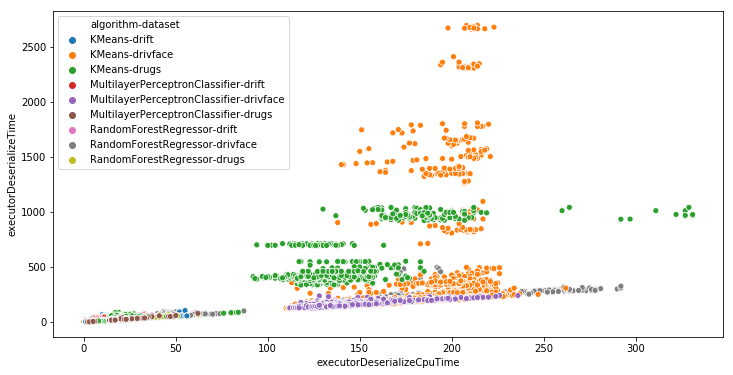

In [591]:
data = stick(spark, 'algorithm', 'dataset')

plt.figure(figsize=(12, 6))
sns.scatterplot(x='executorDeserializeCpuTime', y='executorDeserializeTime', hue='algorithm-dataset', data=data.reset_index())

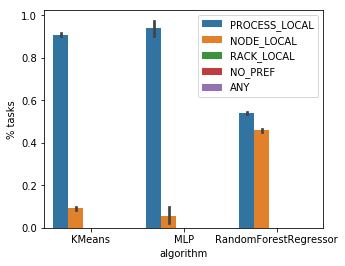

In [93]:
data = spark.reset_index(drop=True).groupby(['dataset', 'algorithm', 'runId', 'taskLocality']).agg({'taskId': 'count'}).unstack().apply(lambda x: x / x.sum(), axis=1).stack().rename(columns={'taskId': '% tasks'}).reset_index()
data['algorithm'] = data['algorithm'].map(lambda alg: 'MLP' if alg == 'MultilayerPerceptronClassifier' else alg)

plt.figure(figsize=(5, 4))
sns.barplot(x='algorithm', y='% tasks', hue='taskLocality', data=data)
plt.legend(loc='upper right')
plt.savefig('graphs/proportions.png')

In [77]:
with pd.option_context('display.max_column', 0):
    display(spark.loc[('drivface', 'KMeans', 2, slice(490, 600))][:10])

jobId jobGroup stageId taskId     launchTime  ...  shuffleRecordsWritten   dataset      family algorithm runId
dataset  algorithm runId taskId                                               ...                                                             
drivface KMeans    2     490       29      NaN      50    490  1551698249301  ...                      1  drivface  clustering    KMeans     2
                         491       29      NaN      50    491  1551698249302  ...                      2  drivface  clustering    KMeans     2
                         492       29      NaN      50    492  1551698249302  ...                      1  drivface  clustering    KMeans     2
                         493       29      NaN      51    493  1551698249866  ...                      0  drivface  clustering    KMeans     2
                         494       29      NaN      51    494  1551698249867  ...                      0  drivface  clustering    KMeans     2
                         495       29      NaN      51    495  1551698249867  ...                      0  drivface  clustering    KMeans     2
                         496       29      NaN      51    496  1551698249867  ...                      0  drivface  clustering    KMeans     2
                         497       29      NaN      51    497  1551698249867  ...                      0  drivface  clustering    KMeans     2
                         498       29      NaN      51    498  1551698249868  ...                      0  drivface  clustering    KMeans     2
                         499       29      NaN      51    499  1551698249868  ...                      0  drivface  clustering    KMeans     2

[10 rows x 41 columns]

In [71]:
with pd.option_context('display.max_column', 0):
    display(spark.loc[('drivface', 'KMeans', 4)][spark.loc[('drivface', 'KMeans', 4)]['duration'] > 2500][:10])

,jobId,jobGroup,stageId,taskId,launchTime,finishTime,duration,schedulerDelay,executorId,host,taskLocality,speculative,gettingResultTime,successful,executorRunTime,executorCpuTime,executorDeserializeTime,executorDeserializeCpuTime,resultSerializationTime,jvmGCTime,resultSize,numUpdatedBlockStatuses,diskBytesSpilled,memoryBytesSpilled,peakExecutionMemory,recordsRead,bytesRead,recordsWritten,bytesWritten,shuffleFetchWaitTime,shuffleTotalBytesRead,shuffleTotalBlocksFetched,shuffleLocalBlocksFetched,shuffleRemoteBlocksFetched,shuffleWriteTime,shuffleBytesWritten,shuffleRecordsWritten,dataset,family,algorithm,runId
taskId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
493,29,NaN,51,493,1551698437423,1551698440130,2707,25,3,172.16.48.12,NODE_LOCAL,False,0,True,2406,18,276,224,0,998,3177,0,0,0,4456448,0,0,0,0,1379,564,9,2,7,0,0,0,drivface,clustering,KMeans,4
494,29,NaN,51,494,1551698437423,1551698440120,2697,27,2,172.16.48.7,NODE_LOCAL,False,0,True,2359,121,311,212,0,141,3177,0,0,0,4456448,0,0,0,0,2234,315,5,1,4,0,0,0,drivface,clustering,KMeans,4
495,29,NaN,51,495,1551698437424,1551698440120,2696,29,1,172.16.48.4,NODE_LOCAL,False,0,True,2391,76,276,222,0,773,3173,0,0,0,4456448,0,0,0,0,1518,354,6,2,4,0,0,0,drivface,clustering,KMeans,4
498,29,NaN,51,498,1551698437424,1551698440229,2805,27,4,172.16.48.1,PROCESS_LOCAL,False,0,True,100,76,2677,223,1,2419,3199,0,0,0,262144,0,0,0,0,0,0,0,0,0,0,0,0,drivface,clustering,KMeans,4
503,29,NaN,51,503,1551698437425,1551698440233,2808,26,4,172.16.48.1,PROCESS_LOCAL,False,0,True,110,79,2672,211,0,2419,3156,0,0,0,262144,0,0,0,0,0,0,0,0,0,0,0,0,drivface,clustering,KMeans,4
508,29,NaN,51,508,1551698437426,1551698440232,2806,28,4,172.16.48.1,PROCESS_LOCAL,False,0,True,86,69,2692,208,0,2419,3156,0,0,0,262144,0,0,0,0,0,0,0,0,0,0,0,0,drivface,clustering,KMeans,4
513,29,NaN,51,513,1551698437427,1551698440230,2803,26,4,172.16.48.1,PROCESS_LOCAL,False,0,True,96,75,2681,213,0,2419,3156,0,0,0,262144,0,0,0,0,0,0,0,0,0,0,0,0,drivface,clustering,KMeans,4
518,29,NaN,51,518,1551698437428,1551698440237,2809,24,4,172.16.48.1,PROCESS_LOCAL,False,0,True,105,80,2680,212,0,2419,3156,0,0,0,262144,0,0,0,0,0,0,0,0,0,0,0,0,drivface,clustering,KMeans,4
523,29,NaN,51,523,1551698437429,1551698440228,2799,24,4,172.16.48.1,PROCESS_LOCAL,False,0,True,106,76,2669,198,0,2419,3156,0,0,0,262144,0,0,0,0,0,0,0,0,0,0,0,0,drivface,clustering,KMeans,4


In [72]:
data = spark.loc[('drivface', 'KMeans', slice(4, 5))].reset_index(drop=True)
data['run'] = data['runId'].map(lambda runId: 'anomaly' if runId == 4 else 'normal')

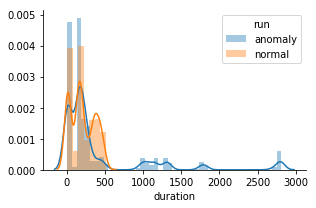

In [74]:
grid = sns.FacetGrid(data, hue='run', legend_out=False, height=3, aspect=1.5)
grid = grid.map(sns.distplot, 'duration')
grid.add_legend()
plt.savefig('graphs/normal_anomaly.png')

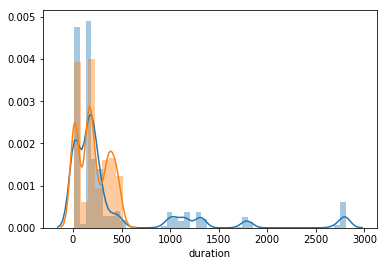

In [46]:
sns.distplot(spark.loc[('drivface', 'KMeans', 4)]['duration'])
sns.distplot(spark.loc[('drivface', 'KMeans', 5)]['duration'])

In [45]:
spark.loc[('drivface', 'KMeans')].groupby(level=['runId']).agg({'duration': 'mean'})

,duration
runId,
1,380.524962
2,261.347958
3,248.040847
4,405.909228
5,207.567322


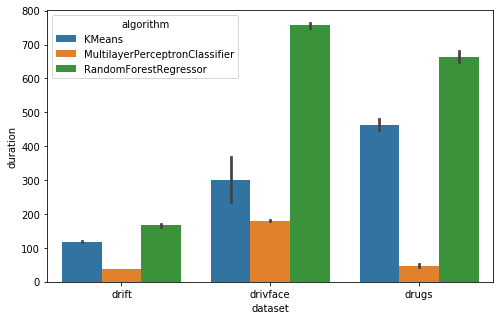

In [44]:
data = spark.reset_index(drop=True).groupby(['dataset', 'algorithm', 'runId']).agg({'duration': 'mean'})

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='duration', hue='algorithm', data=data.reset_index())

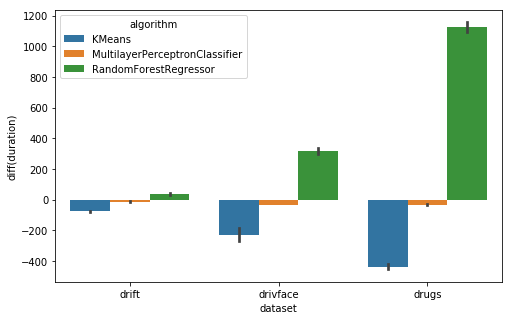

In [679]:
data = spark.groupby(['dataset', 'algorithm', 'runId', 'taskLocality']).agg({'duration': 'mean'}).unstack().diff(axis=1).stack().rename(columns={'duration': 'diff(duration)'})

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='diff(duration)', hue='algorithm', data=data.reset_index())

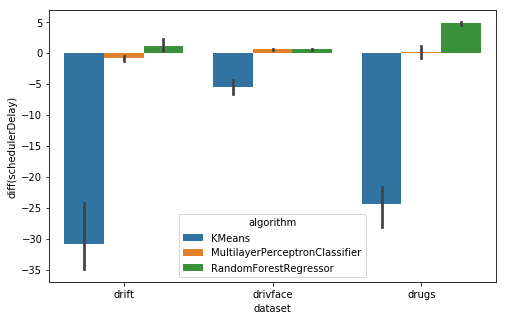

In [544]:
data = spark.groupby(['dataset', 'algorithm', 'runId', 'taskLocality']).agg({'schedulerDelay': 'mean'}).unstack().diff(axis=1).stack().rename(columns={'schedulerDelay': 'diff(schedulerDelay)'})

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='diff(schedulerDelay)', hue='algorithm', data=data.reset_index())

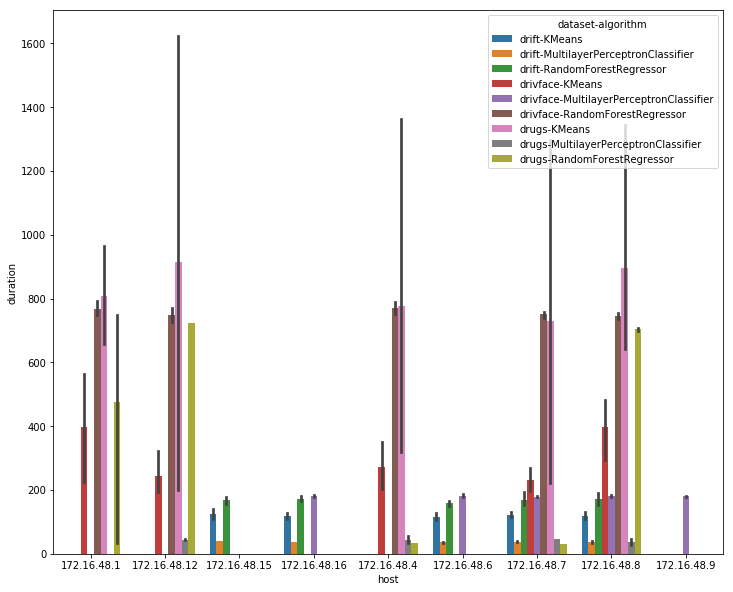

In [54]:
data = stick(spark.groupby(['algorithm', 'dataset', 'runId', 'host']).agg({'duration': 'mean'}).reset_index(), 'dataset', 'algorithm')

plt.figure(figsize=(12, 10))
sns.barplot(x='host', y='duration', hue='dataset-algorithm', data=data.reset_index())

In [39]:
spark.groupby(['dataset', 'algorithm', 'runId']).agg({'jobId': 'nunique', 'stageId': 'nunique', 'executorId': 'nunique', 'taskId': 'nunique', 'host': 'nunique'})

jobId  stageId  executorId  \
dataset  algorithm                      runId                               
drift    KMeans                         1         17       28           5   
                                        2         17       28           5   
                                        3         17       28           5   
                                        4         17       28           5   
                                        5         17       28           5   
         MultilayerPerceptronClassifier 1        212      213           5   
                                        2        213      214           5   
                                        3        205      206           5   
                                        4        202      203           5   
                                        5        238      239           5   
         RandomForestRegressor          1         15       27           5   
                                        2         15       27           5   
                                        3         15       27           5   
                                        4         15       27           5   
                                        5         15       27           5   
drivface KMeans                         1         27       48           5   
                                        2         27       48           5   
                                        3         27       48           5   
                                        4         27       48           5   
                                        5         27       48           5   
         MultilayerPerceptronClassifier 1         66      131           5   
                                        2         67      133           5   
                                        3         64      127           5   
                                        4         66      131           5   
                                        5         65      129           5   
         RandomForestRegressor          1         29       55           5   
                                        2         29       55           5   
                                        3         29       55           5   
                                        4         29       55           5   
                                        5         29       55           5   
drugs    KMeans                         1         21       36           5   
                                        2         21       36           5   
                                        3         21       36           5   
                                        4         21       36           5   
                                        5         21       36           5   
         MultilayerPerceptronClassifier 1        122      123           2   
                                        2        121      122           1   
                                        3        126      127           1   
                                        4        129      130           1   
                                        5        125      126           2   
         RandomForestRegressor          1         15       27           2   
                                        2         15       27           2   
                                        3         15       27           1   
                                        4         15       27           2   
                                        5         15       27           2   

                                               taskId  host  
dataset  algorithm                      runId                
drift    KMeans                         1         331     5  
                                        2         331     5  
                                        3         331     5  
                                        4         331     5  
                                        5         331  

<Figure size 7200x7200 with 0 Axes>

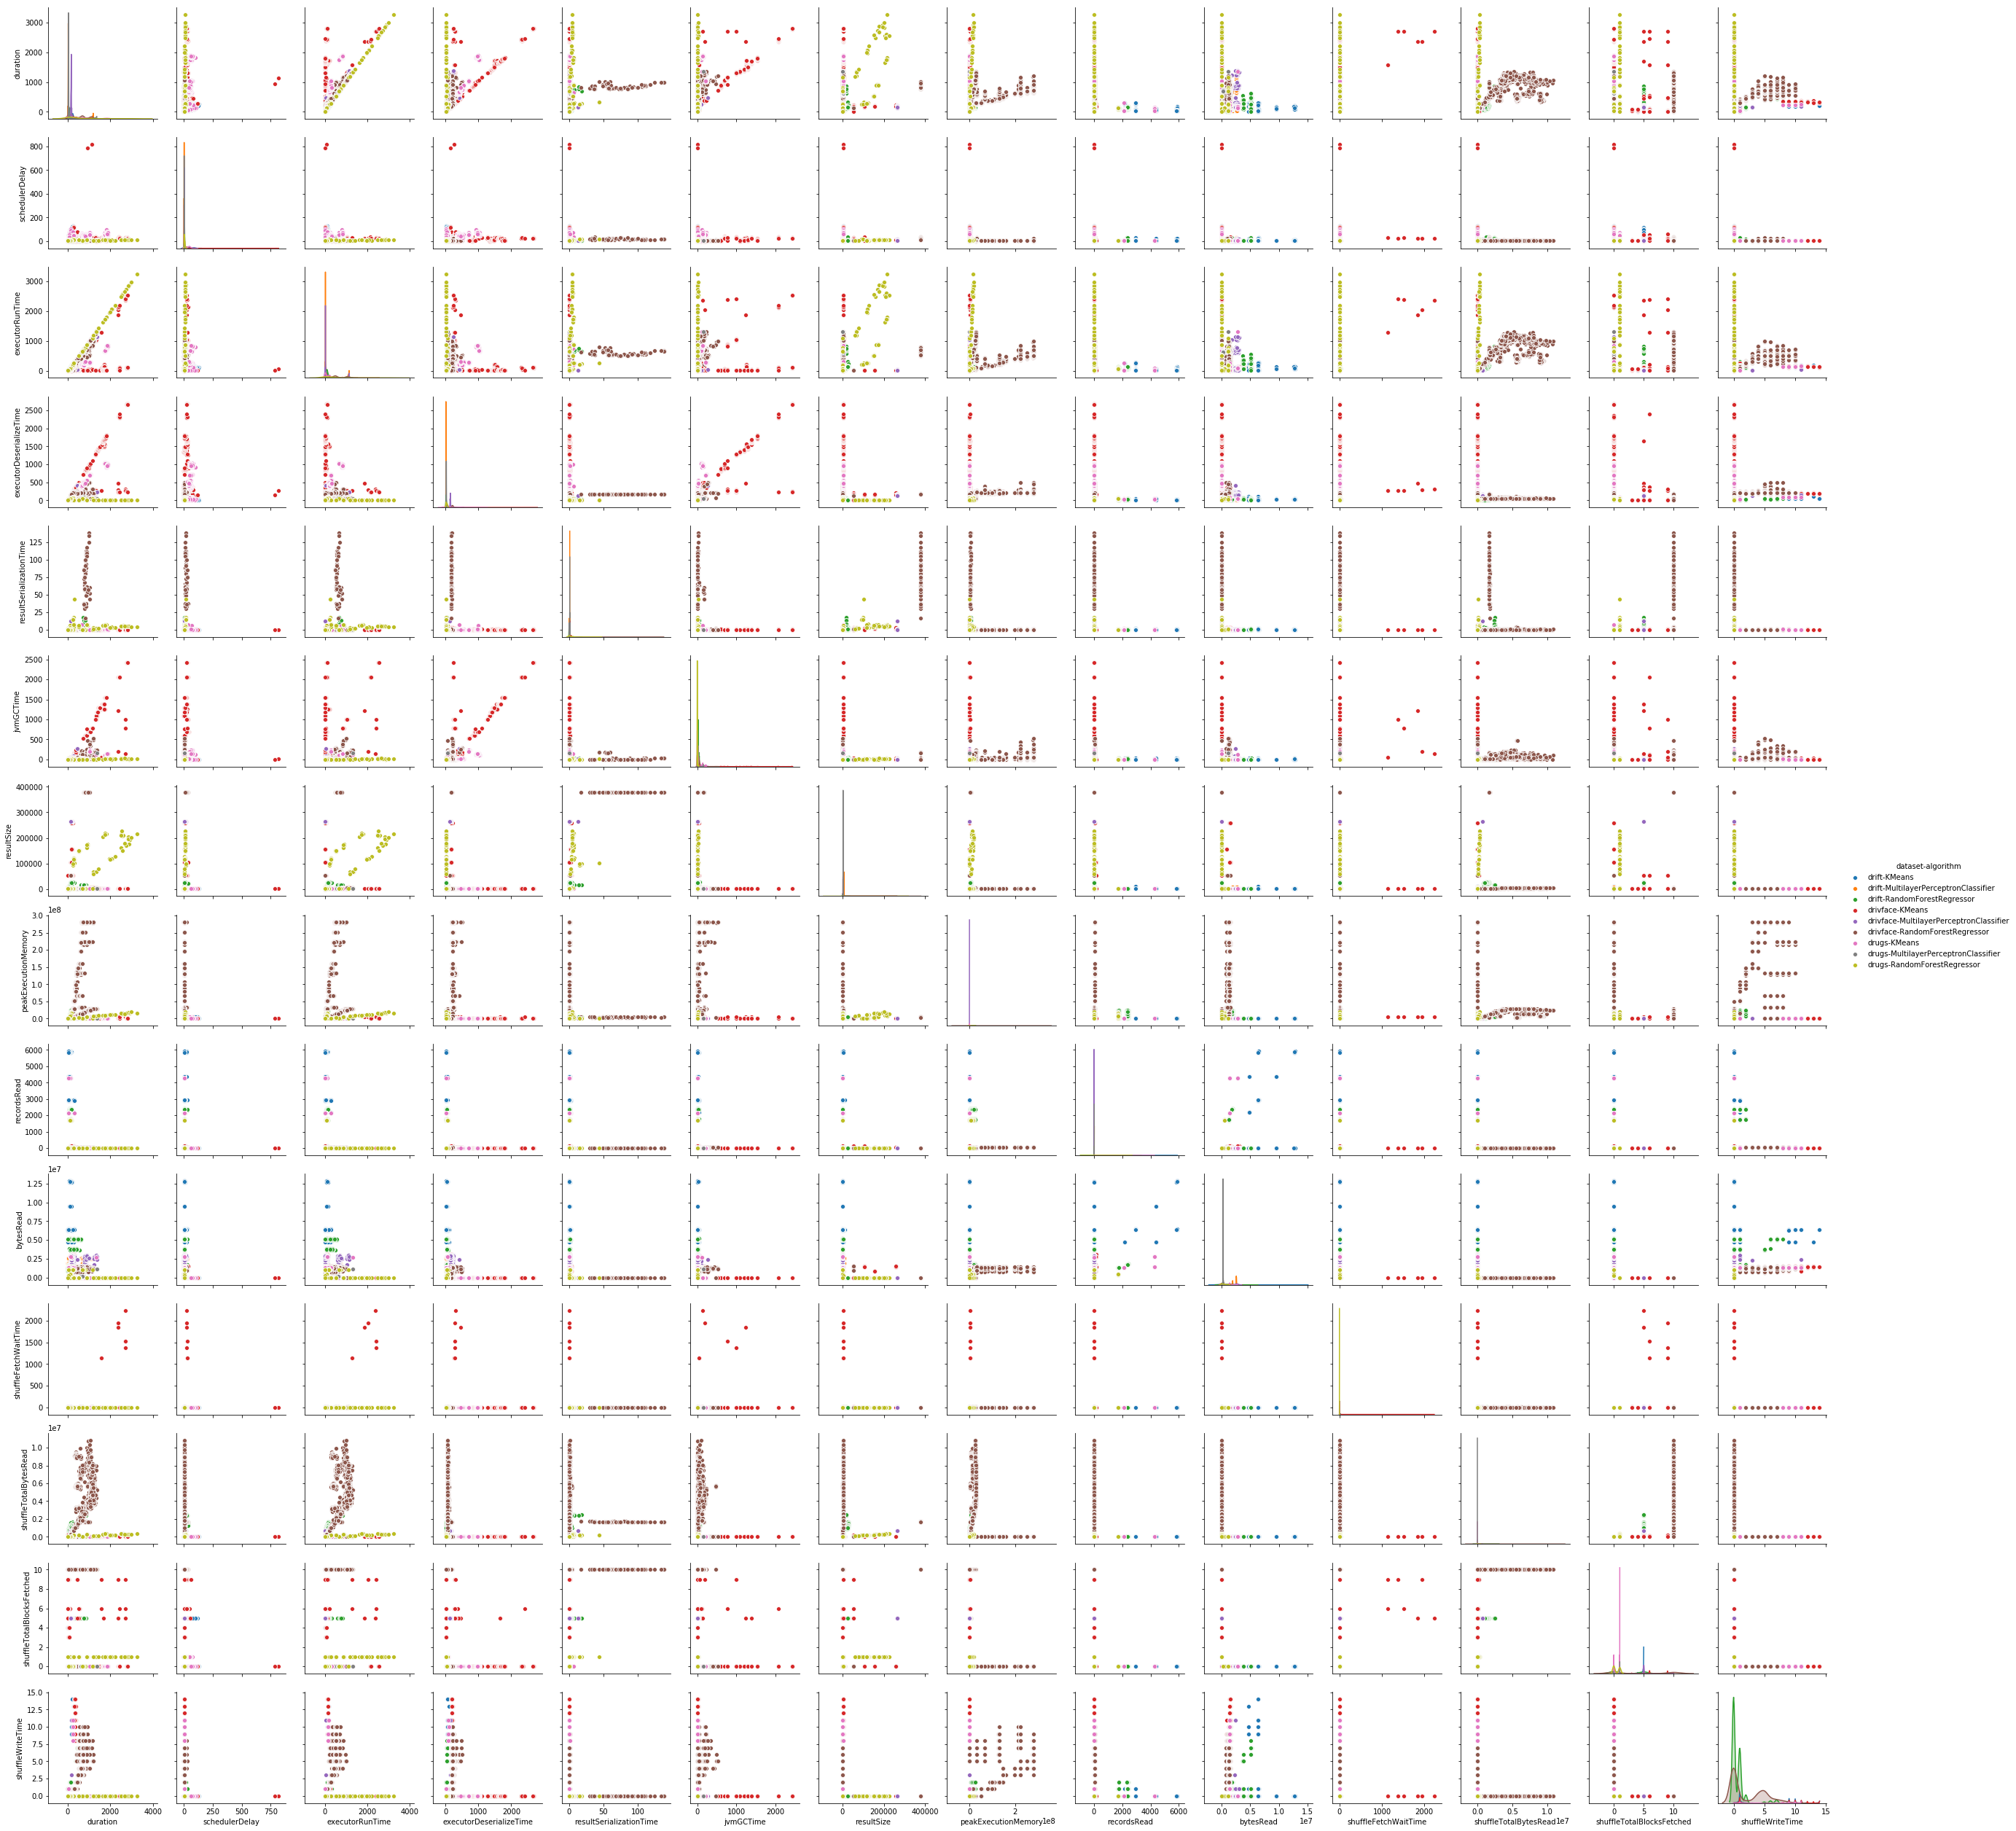

In [609]:
data = stick(spark, 'dataset', 'algorithm').drop(columns=[
    'jobId', 'stageId', 'taskId', 'executorId', 'host', 'family', 'runId', 'executorCpuTime', 'executorDeserializeCpuTime',
    'shuffleLocalBlocksFetched', 'shuffleRemoteBlocksFetched', 'shuffleBytesWritten', 'shuffleRecordsWritten', 'taskLocality'
])

plt.figure(figsize=(100, 100))
sns.pairplot(hue='dataset-algorithm', data=data)

### Descriptive Analysis

In [3]:
full.shape

(19404, 55)

In [4]:
full.nunique()

jobId                           239
jobGroup                          0
stageId                         241
taskId                         1209
launchTime                     7964
finishTime                    14919
duration                       1431
schedulerDelay                  121
executorId                        5
host                              9
taskLocality                      2
speculative                       1
gettingResultTime                 1
successful                        1
executorRunTime                1063
executorCpuTime                 871
executorDeserializeTime         721
executorDeserializeCpuTime      258
resultSerializationTime          54
jvmGCTime                       209
resultSize                      464
numUpdatedBlockStatuses           1
diskBytesSpilled                  1
memoryBytesSpilled                1
peakExecutionMemory            1583
recordsRead                      88
bytesRead                       481
recordsWritten              

In [62]:
full.isnull().any()

jobId                         False
jobGroup                       True
stageId                       False
taskId                        False
launchTime                    False
finishTime                    False
duration                      False
schedulerDelay                False
executorId                    False
host                          False
taskLocality                  False
speculative                   False
gettingResultTime             False
successful                    False
executorRunTime               False
executorCpuTime               False
executorDeserializeTime       False
executorDeserializeCpuTime    False
resultSerializationTime       False
jvmGCTime                     False
resultSize                    False
numUpdatedBlockStatuses       False
diskBytesSpilled              False
memoryBytesSpilled            False
peakExecutionMemory           False
recordsRead                   False
bytesRead                     False
recordsWritten              

In [5]:
with pd.option_context('display.max_column', 0):
    display(full.describe())

,launchTime,finishTime,duration,schedulerDelay,gettingResultTime,executorRunTime,executorCpuTime,executorDeserializeTime,executorDeserializeCpuTime,resultSerializationTime,jvmGCTime,resultSize,numUpdatedBlockStatuses,diskBytesSpilled,memoryBytesSpilled,peakExecutionMemory,recordsRead,bytesRead,recordsWritten,bytesWritten,shuffleFetchWaitTime,shuffleTotalBytesRead,shuffleTotalBlocksFetched,shuffleLocalBlocksFetched,shuffleRemoteBlocksFetched,shuffleWriteTime,shuffleBytesWritten,shuffleRecordsWritten,accuracy,f1,features,fitTime,mae,mse,r2,rmse,silhouette,testCount,trainCount,transformTime,weightedPrecision,weightedRecall
count,1.940400e+04,1.940400e+04,19404.000000,19404.000000,19404.0,19404.000000,19404.000000,19404.000000,19404.000000,19404.000000,19404.000000,19404.000000,19404.0,19404.0,19404.0,1.940400e+04,19404.000000,1.940400e+04,19404.0,19404.0,19404.000000,1.940400e+04,19404.000000,19404.000000,19404.000000,19404.000000,1.940400e+04,19404.000000,9904.000000,9904.000000,19404.000000,19404.000000,3365.000000,3365.000000,3365.000000,3365.000000,6135.000000,19404.000000,19404.000000,19404.000000,9904.000000,9904.000000
mean,1.551756e+12,1.551756e+12,249.683519,10.305556,0.0,127.773140,103.409503,111.295764,70.714646,0.309060,28.039064,15206.692538,0.0,0.0,0.0,1.506158e+07,119.381571,1.479872e+06,0.0,0.0,0.599516,3.192306e+05,1.043084,0.220573,0.822511,0.369202,3.192306e+05,1140.243403,0.146261,0.072549,3310.722222,37427.133065,1.796859,10.781571,0.901276,2.980062,0.586736,2327.492837,5078.550763,1543.217996,0.100280,0.146261
std,4.856974e+07,4.856957e+07,360.012438,18.622466,0.0,270.145431,238.860352,205.260240,71.377500,4.151821,161.681958,51080.010788,0.0,0.0,0.0,5.662794e+07,590.997935,1.429085e+06,0.0,0.0,31.290614,1.177663e+06,2.744868,0.566913,2.187457,1.442485,1.163631e+06,18268.593827,0.123178,0.065935,3155.623305,32679.502757,0.827514,6.006529,0.311684,1.378900,0.087709,3712.770989,5430.159098,1416.417074,0.082412,0.123178
min,1.551695e+12,1.551695e+12,11.000000,1.000000,0.0,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,1134.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,13.000000,3402.000000,0.084254,0.045374,-0.690844,0.213011,0.529388,106.000000,469.000000,132.000000,0.000000,0.000000
25%,1.551698e+12,1.551698e+12,34.000000,3.000000,0.0,16.000000,12.000000,10.000000,7.000000,0.000000,0.000000,2179.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,135.000000,15146.000000,1.962965,7.742834,0.956368,2.782595,0.529388,132.000000,489.000000,239.000000,0.000000,0.000000
50%,1.551794e+12,1.551794e+12,154.000000,5.000000,0.0,20.000000,16.000000,45.000000,23.000000,0.000000,0.000000,3113.000000,0.0,0.0,0.0,2.610480e+05,1.000000,1.451312e+06,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.211810,0.075064,6420.000000,22442.000000,2.215061,11.758218,0.959781,3.429026,0.529388,606.000000,606.000000,1965.000000,0.152786,0.211810
75%,1.551794e+12,1.551794e+12,230.000000,6.000000,0.0,78.000000,49.000000,147.000000,132.000000,0.000000,0.000000,7768.000000,0.0,0.0,0.0,2.621440e+05,19.000000,2.545360e+06,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,6.569100e+04,1.000000,0.245002,0.130261,6420.000000,70821.000000,2.252216,15.864951,0.974184,3.983083,0.730695,2751.000000,11159.000000,2408.000000,0.166017,0.245002
max,1.551802e+12,1.551802e+12,3264.000000,816.000000,0.0,3239.000000,3227.000000,2692.000000,331.000000,138.000000,2419.000000,378272.000000,0.0,0.0,0.0,2.817045e+08,5906.000000,1.284000e+07,0.0,0.0,2234.000000,1.085560e+07,10.000000,2.000000,8.000000,14.000000,1.102649e+07,359351.000000,0.374065,0.203665,6423.000000,91281.000000,2.962587,17.931960,0.984704,4.234615,0.730695,13910.000000,13910.000000,3958.000000,0.203143,0.374065


In [32]:
full = full.drop(columns=['launchTime', 'finishTime', *full.nunique()[(full.nunique() <= 1)].index])

In [29]:
import math
import warnings

warnings.simplefilter('ignore')

In [33]:
data = full.drop(columns=[*appli['metric'].unique(), *full.columns[full.dtypes == 'category']])

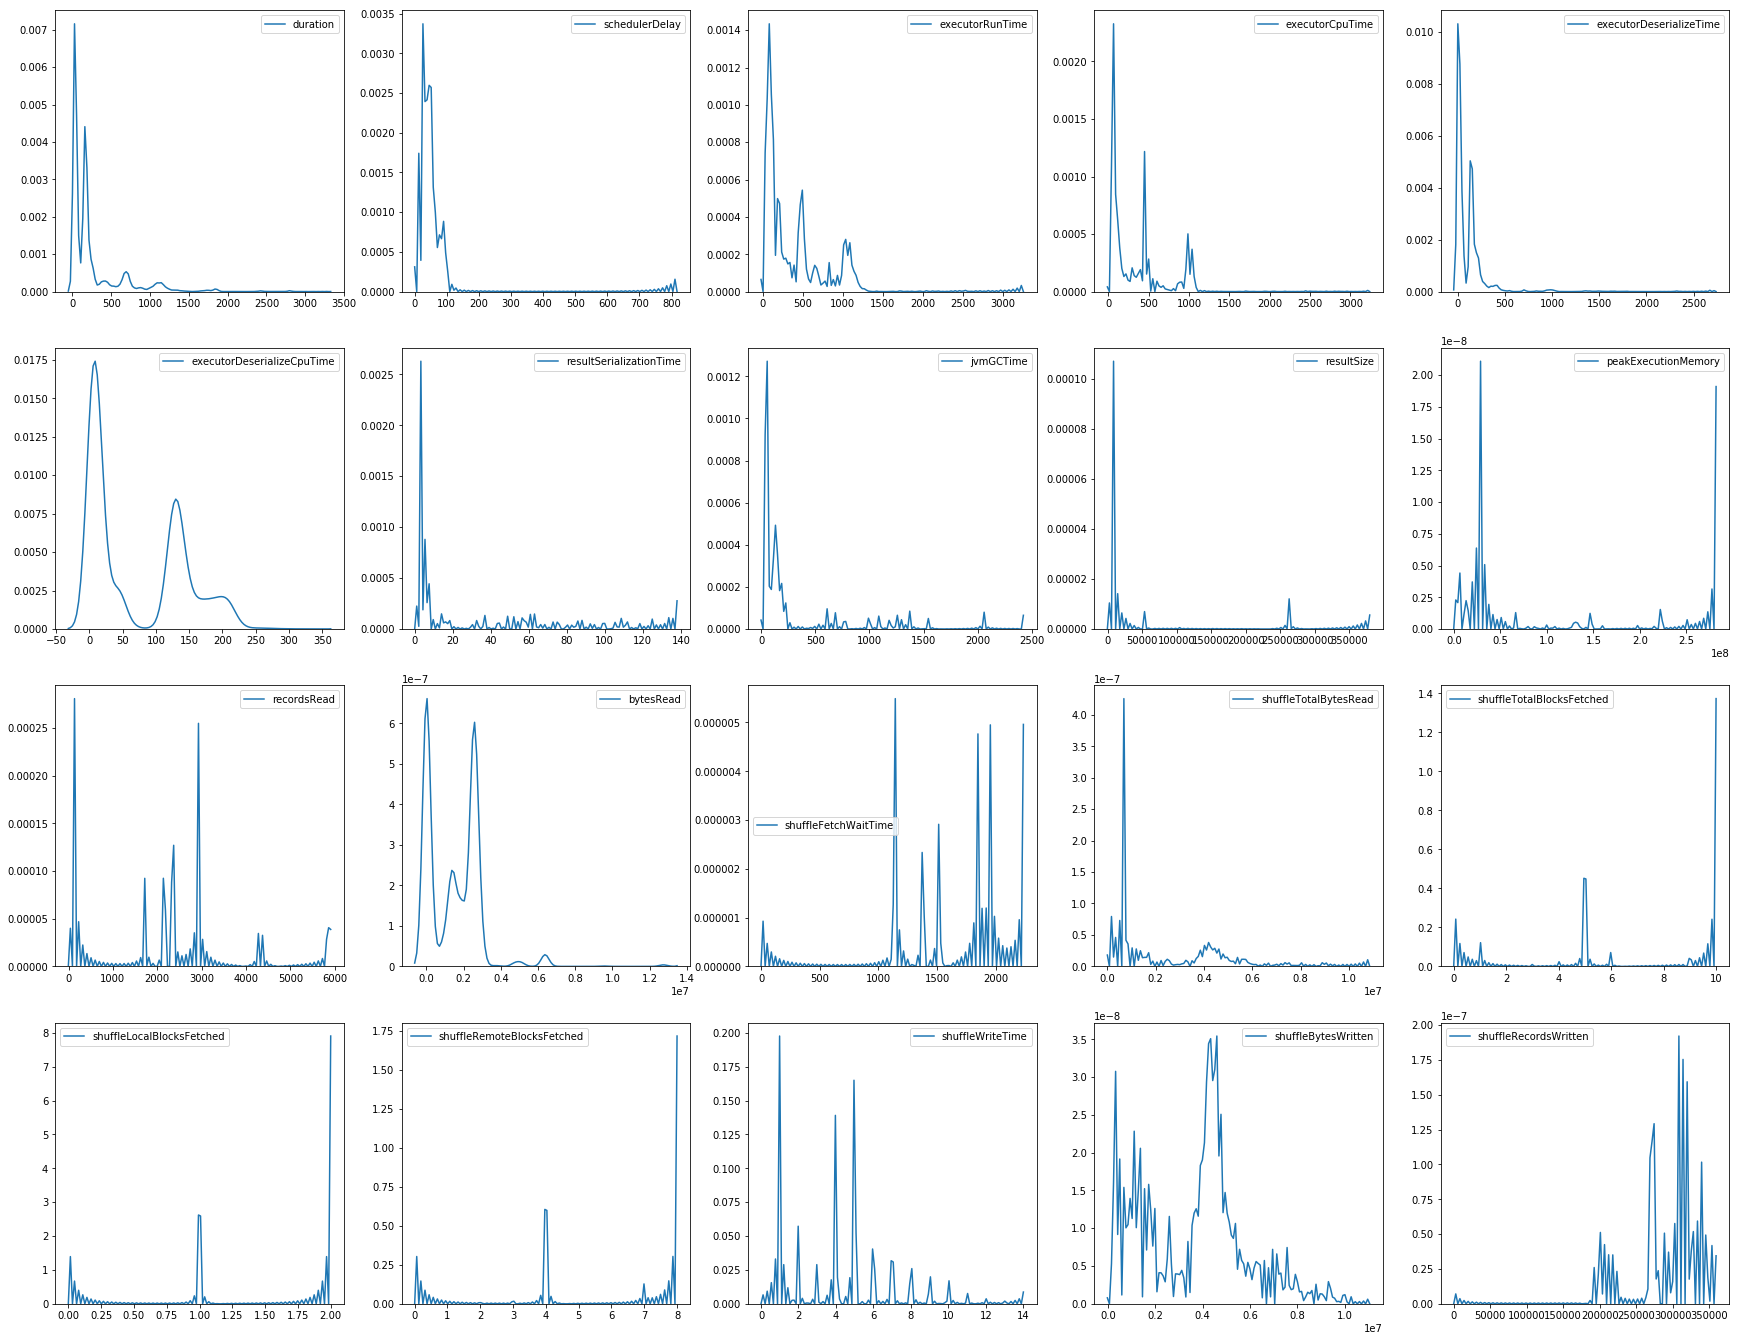

In [42]:
print_distributions(data, gridsize=100)

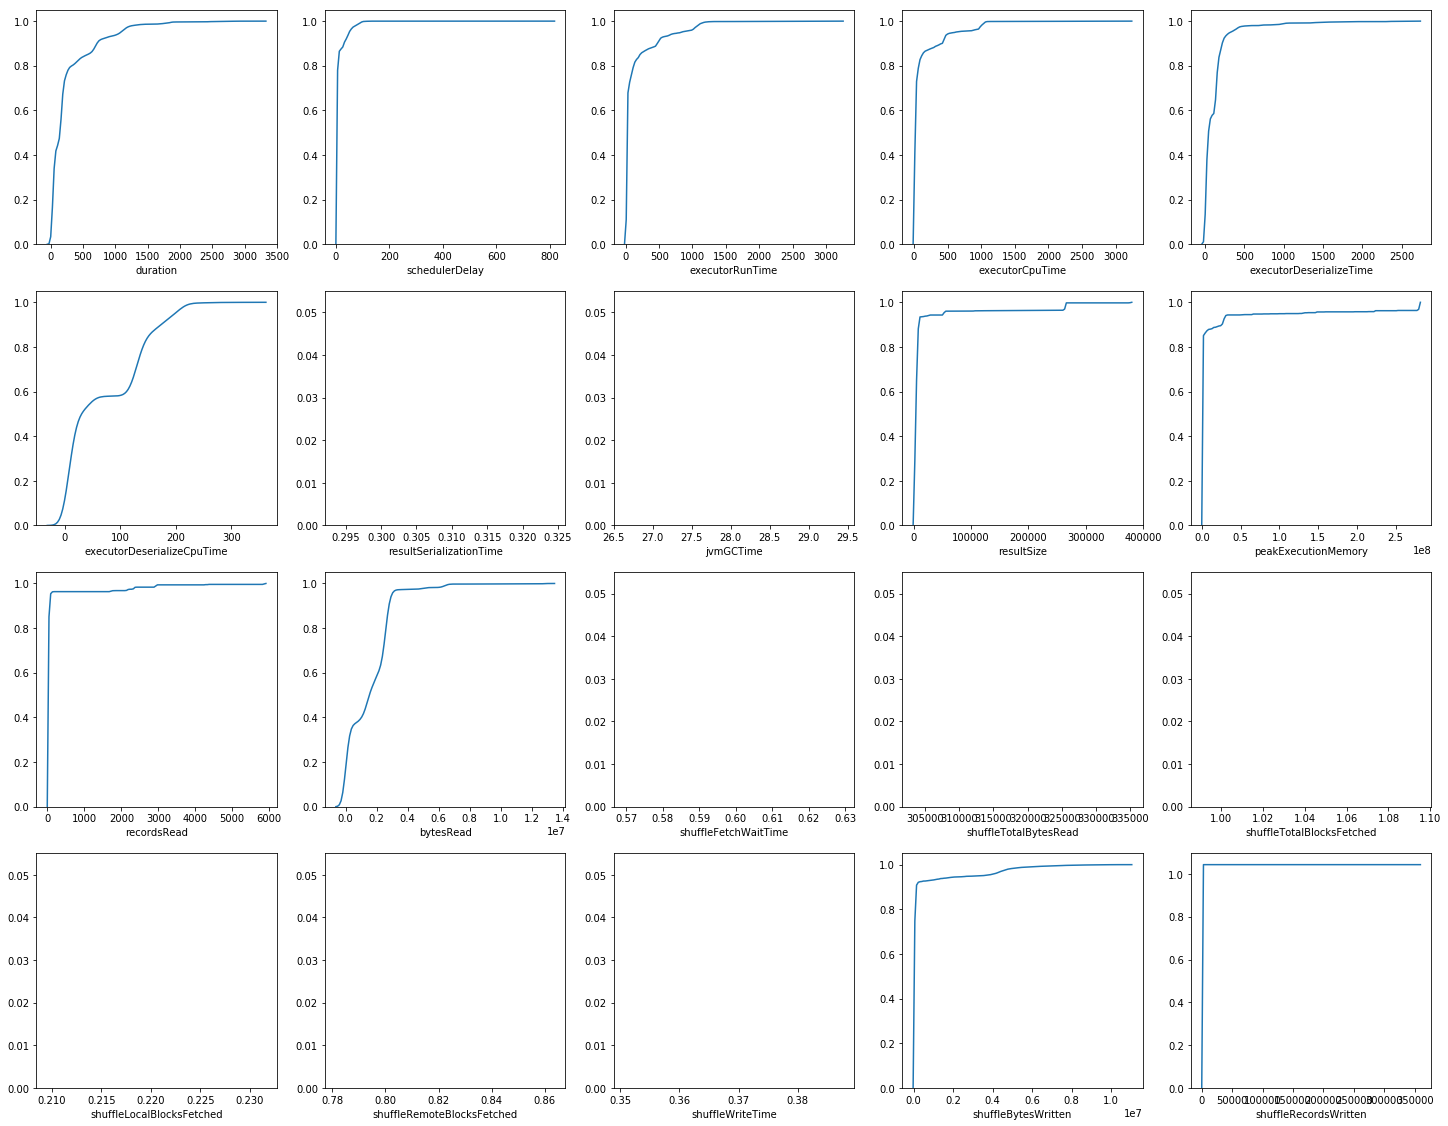

In [69]:
print_distributions(data, cumulative=True)

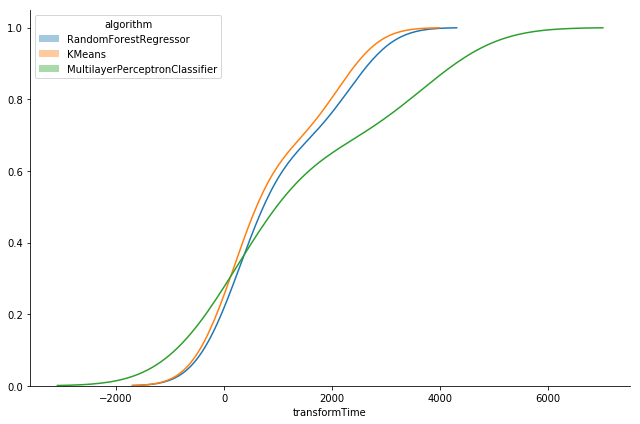

In [67]:
multidistplot(df.reset_index(drop=True).groupby(['configurationId']).agg({'transformTime': 'first', 'algorithm': 'first'}).reset_index(), 'transformTime', hue='algorithm', height=6, aspect=1.5, kde_kws={'cumulative': True})

In [ ]:
grid = sns.FacetGrid(data, hue='run', legend_out=False, height=3, aspect=1.5)
grid = grid.map(sns.distplot, 'duration')
grid.add_legend()
plt.savefig('graphs/normal_anomaly.png')

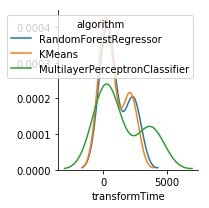

In [59]:
grid = sns.FacetGrid(df.reset_index(drop=True).groupby(['configurationId']).agg({'transformTime': 'first', 'algorithm': 'first'}).reset_index(), hue='algorithm', legend_out=False, height=6, aspect=1.5)
grid = grid.map(sns.distplot, 'transformTime', hist=False, kde_kws={'cumulative': False})
grid.add_legend()

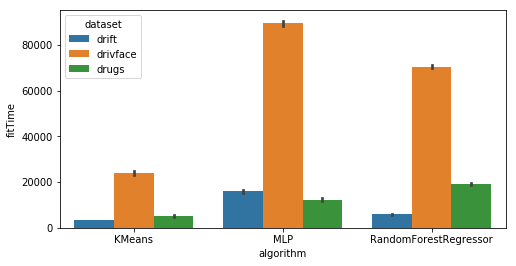

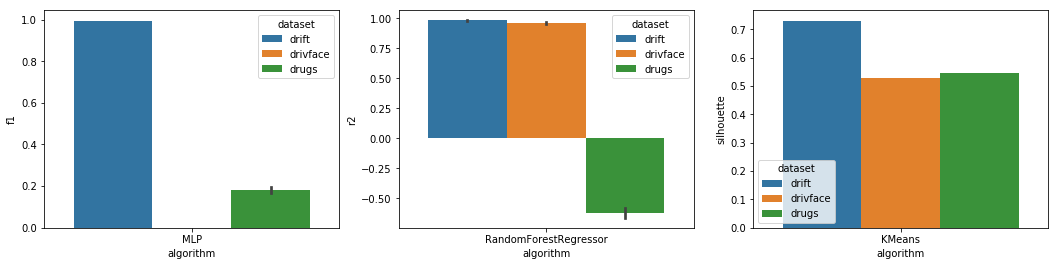

In [456]:
data = metrics.reset_index(drop=True).groupby(['dataset', 'algorithm', 'runId']).agg({'fitTime': 'first', 'f1': 'first', 'r2': 'first', 'silhouette': 'first', 'family': 'first'})

plt.figure(figsize=(8, 4))
sns.barplot(x='algorithm', y='fitTime', hue='dataset', data=data.reset_index())
plt.savefig('graphs/transform_time.png')

plt.figure(figsize=(18, 4))
plt.subplot(131)
sns.barplot(x='algorithm', y='f1', hue='dataset', data=data[data['family'] == 'classification'].reset_index())
plt.subplot(132)
sns.barplot(x='algorithm', y='r2', hue='dataset', data=data[data['family'] == 'regression'].reset_index())
plt.subplot(133)
sns.barplot(x='algorithm', y='silhouette', hue='dataset', data=data[data['family'] == 'clustering'].reset_index())
plt.savefig('graphs/accuracy.png')

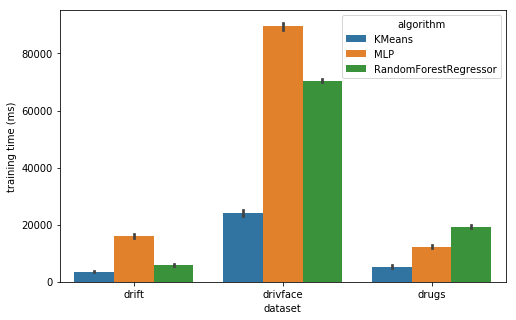

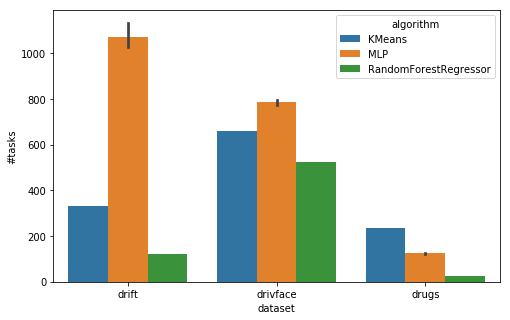

In [460]:
data = metrics.reset_index(drop=True).groupby(['dataset', 'algorithm', 'runId']).agg({'fitTime': 'first', 'taskId': 'count'}).rename(columns={'taskId': '#tasks', 'fitTime': 'training time (ms)'})

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='training time (ms)', hue='algorithm', data=data.reset_index())
plt.savefig('graphs/fit_time.png')

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='#tasks', hue='algorithm', data=data.reset_index())
plt.savefig('graphs/nb_tasks.png')

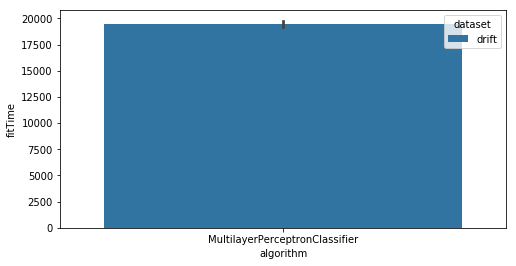

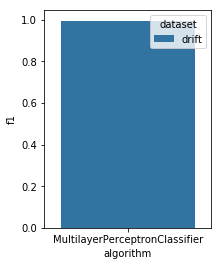

In [327]:
data = metrics.reset_index(drop=True).groupby(['dataset', 'algorithm', 'runId']).agg({'fitTime': 'first', 'f1': 'first', 'family': 'first'})

plt.figure(figsize=(8, 4))
sns.barplot(x='algorithm', y='fitTime', hue='dataset', data=data.reset_index())
plt.savefig('graphs/transform_time.png')

plt.figure(figsize=(3, 4))
sns.barplot(x='algorithm', y='f1', hue='dataset', data=data[data['family'] == 'classification'].reset_index())
plt.savefig('graphs/accuracy.png')

In [294]:
metrics['executorCpuUsage'] = metrics['executorCpuTime'] / metrics['executorRunTime']
r = metrics.loc[(6)].copy()
interval = 0
for run_id, df in r.reset_index(drop=True).groupby(['runId']):
    size = df['finishTime'].max() - df['launchTime'].min()
    if size > interval:
        interval = size
interval = interval / 1000
times = np.linspace(0, interval, num=66)

In [295]:
res_y = []
for run_id, df in r.reset_index(drop=True).groupby(['runId']):
    x = []
    y = []
    offset = df['launchTime'].min()
    for t in tqdm(times):
        m = 0
        for i, row in df.iterrows():
            if (row['launchTime'] - offset)/1000 <= t < (row['finishTime']-offset)/1000:
                m += row['executorCpuUsage']
        y.append(m)
    res_y.append(y)

100%|██████████| 66/66 [00:11<00:00,  5.83it/s]


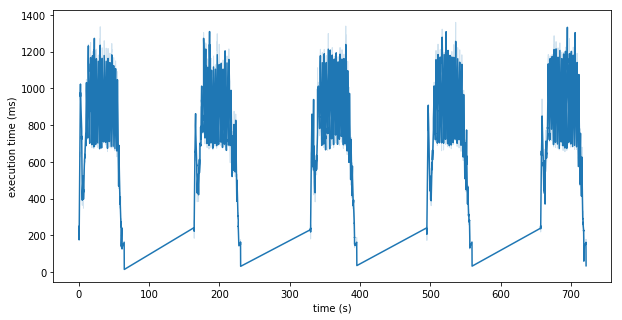

In [507]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="time (s)", y="schedulerDelay", data=r, markers=False)

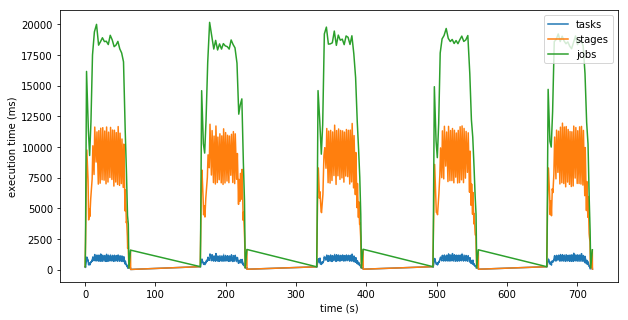

In [486]:
r = metrics.loc[(1)].rename(columns={'duration': 'execution time (ms)'})
r['time (s)'] = (r['launchTime'] - r['launchTime'].min()) / 1000
#r['tick'] = r['tick'] - r['tick'].min()
c = r.reset_index(drop=True).groupby(['runId', 'stageId']).agg({'execution time (ms)': 'sum', 'time (s)': 'mean', 'runId': 'first'})
f = r.reset_index(drop=True).groupby(['runId', 'jobId']).agg({'execution time (ms)': 'sum', 'time (s)': 'mean', 'runId': 'first'})

plt.figure(figsize=(10, 5))
sns.lineplot(x="time (s)", y="execution time (ms)", data=r, markers=False)
sns.lineplot(x="time (s)", y="execution time (ms)", data=c, markers=True)
sns.lineplot(x="time (s)", y="execution time (ms)", data=f, markers=True)
plt.gca().legend(('tasks', 'stages', 'jobs'))
plt.savefig('graphs/time_series.png')

In [218]:
metrics['taskId'] = metrics['taskId'].astype(int)
metrics['jobId'] = metrics['jobId'].astype(int)
metrics['stageId'] = metrics['stageId'].astype(int)

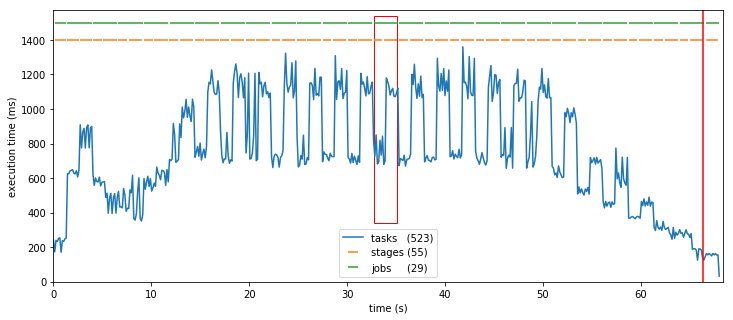

In [625]:
import matplotlib.patches as patches

data = metrics.loc[(1, 4)].reset_index(drop=True).copy()

data['time'] = (data['taskId'] - data['taskId'].min())

stag = data.groupby(['runId', 'stageId']).agg({"taskId": ['max', 'min']})
stag['size'] = (stag['taskId']['max'] - stag['taskId']['min']) / 2
stag['center'] = stag['size'] + stag['taskId']['min']

jobs = data.groupby(['runId', 'jobId']).agg({"taskId": ['max', 'min']})
jobs['size'] = (jobs['taskId']['max'] - jobs['taskId']['min']) / 2
jobs['center'] = jobs['size'] + jobs['taskId']['min']

alpha = (68 / data['time'].max())
data ['time (s)'] = data['time'] * alpha
data = data.rename(columns={'duration': 'execution time (ms)'})

plt.figure(figsize=(12, 5))

sns.lineplot(x="time (s)", y="execution time (ms)", data=data)

x_stag = (stag['center'] - data['taskId'].min()) * alpha
x_jobs = (jobs['center'] - data['taskId'].min()) * alpha

s_stag = stag['size'] * alpha
s_jobs = jobs['size'] * alpha

y_stag = np.array([1400] * len(stag))
y_jobs = np.array([1500] * len(jobs))

x_stag.iloc[4:-2]   = x_stag.iloc[4:-2] - 0.15
s_stag.iloc[4:-2:2] = s_stag.iloc[4:-2:2] * 0.75
s_stag.iloc[5:-2:2] = s_stag.iloc[3:-2:2] * 1.15

plt.gca().errorbar(x=x_stag, y=y_stag, xerr=s_stag, fmt='.', markersize=0)
plt.gca().errorbar(x=x_jobs, y=y_jobs, xerr=s_jobs, fmt='.', markersize=0)

plt.legend((
    'tasks   ({})'.format(len(data)),
    'stages ({})'.format(len(stag)),
    'jobs     ({})'.format(len(jobs))
))

plt.gca().add_patch(patches.Rectangle((251 * alpha, 340), 18 * alpha, 1200, linewidth=1, edgecolor='r', facecolor='none'))
plt.gca().axvline(x=509 * alpha, color='red')
plt.gca().set_xlim(0, 525 * alpha)
plt.gca().set_ylim(0)

plt.savefig('graphs/serieA.png')

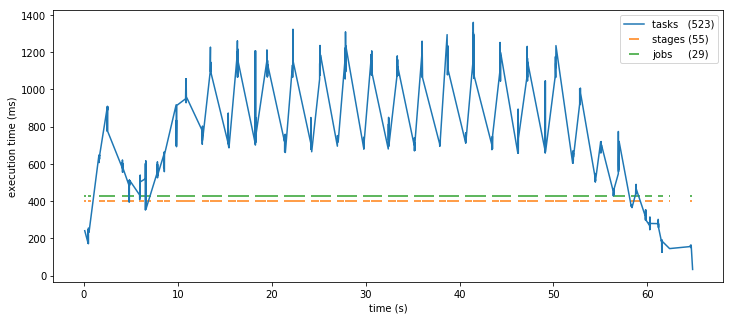

In [633]:
data = metrics.loc[(1, 4)].reset_index(drop=True).copy()
data = data.sort_values(['launchTime', 'taskId'])

data['time'] = (data['launchTime'] - data['launchTime'].min()) / 1000
data['time'] += np.random.rand(len(data['time'])) * 0.1

stag = data.groupby(['runId', 'stageId']).agg({"finishTime": 'max', 'launchTime': 'min'})
stag['size'  ] = (stag['finishTime'] - stag['launchTime']) / 2
stag['center'] = stag['size'] + stag['launchTime']

jobs = data.groupby(['runId', 'jobId']).agg({"finishTime": 'max', 'launchTime': 'min'})
jobs['size'  ] = (jobs['finishTime'] - jobs['launchTime']) / 2
jobs['center'] = jobs['size'] + jobs['launchTime']

data = data.rename(columns={'duration': 'execution time (ms)', 'time': 'time (s)'})

plt.figure(figsize=(12, 5))

sns.lineplot(x="time (s)", y="execution time (ms)", data=data)

plt.gca().errorbar(x=(stag['center'] - data['launchTime'].min()) / 1000 , y=np.array([400] * len(stag)), xerr=stag['size'] / 1000, fmt='.', markersize=0)
plt.gca().errorbar(x=(jobs['center'] - data['launchTime'].min()) / 1000 , y=np.array([430] * len(jobs)), xerr=jobs['size'] / 1000, fmt='.', markersize=0)

plt.legend((
    'tasks   ({})'.format(len(data)),
    'stages ({})'.format(len(stag)),
    'jobs     ({})'.format(len(jobs))
))

plt.savefig('graphs/serieB.png')

In [ ]:
data = metrics.loc[(6, 5)].reset_index(drop=True)[['runId', 'finishTime', 'duration', 'stageId', 'jobId', 'launchTime']]
data.loc[:, 'time'] = (data.loc[:, 'finishTime'] - data.loc[:, 'launchTime'].min()) / 1000
data = data.rename(columns={'duration': 'execution time (ms)', 'time': 'time (s)'})

plt.figure(figsize=(12, 5))
sns.lineplot(x="time (s)", y="execution time (ms)", data=data)
plt.gca().set_xlim(0, 16.5)
plt.gca().set_ylim(0)
plt.savefig('graphs/serieC.png')
plt.show()

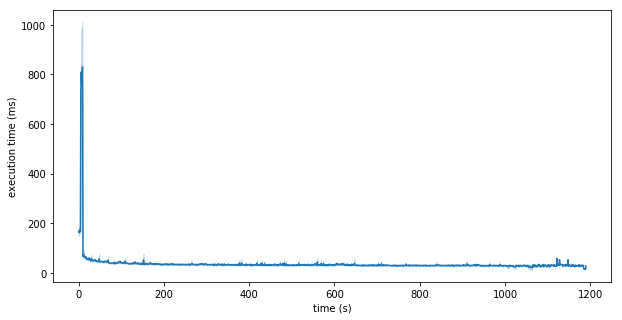

In [131]:
data = metrics.loc[(6)].reset_index(drop=True)
for i in range(1, 6):
    data.loc[data['runId'] == i, 'tick'] = data.loc[data['runId'] == i, 'taskId'].values - data.loc[data['runId'] == i, 'taskId'].min()
data = data.rename(columns={'duration': 'execution time (ms)', 'tick': 'time (s)'})

plt.figure(figsize=(10, 5))
sns.lineplot(x="time (s)", y="execution time (ms)", data=data)

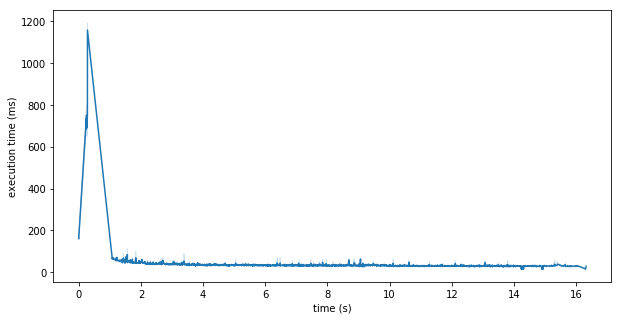

In [121]:
data = metrics.loc[(6)].reset_index(drop=True)
for i in range(1, 6):
    data.loc[data['runId'] == i, 'time'] = (data.loc[data['runId'] == i, 'launchTime'] - data.loc[data['runId'] == i, 'launchTime'].min()) / 1000
data = data.rename(columns={'duration': 'execution time (ms)', 'time': 'time (s)'})

plt.figure(figsize=(10, 5))
sns.lineplot(x="time (s)", y="execution time (ms)", data=data)

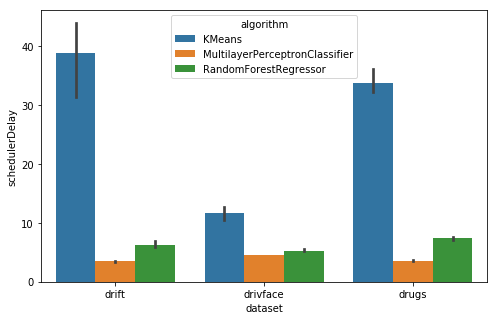

In [368]:
data = metrics.reset_index(drop=True).groupby(['dataset', 'algorithm', 'runId']).agg({'schedulerDelay': 'mean', 'duration': 'sum'})

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='schedulerDelay', hue='algorithm', data=data.reset_index())

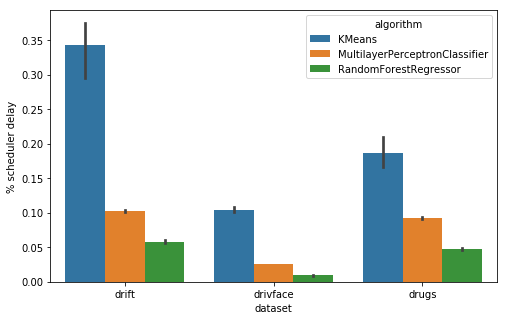

In [395]:
metrics['% scheduler delay'] =  metrics['schedulerDelay'] / metrics['duration']

data = metrics.reset_index(drop=True).groupby(['dataset', 'algorithm', 'runId']).agg({'% scheduler delay': 'mean'})

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='% scheduler delay', hue='algorithm', data=data.reset_index())
plt.savefig('graphs/scheduler.png')

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


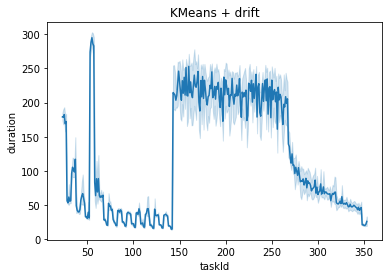

In [442]:
data=metrics[metrics['algorithm'] == 'KMeans'][metrics['dataset'] == 'drift'][['duration', 'schedulerDelay', '% scheduler delay']]
plt.title('KMeans + drift')
sns.lineplot(x='taskId', y='duration', data=data.reset_index())

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


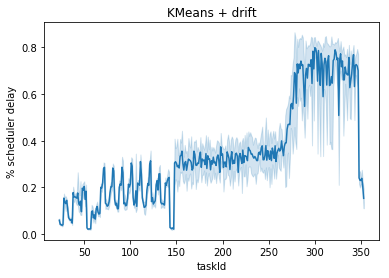

In [410]:
data=metrics[metrics['algorithm'] == 'KMeans'][metrics['dataset'] == 'drift'][['duration', 'schedulerDelay', '% scheduler delay']]
plt.title('KMeans + drift')
sns.lineplot(x='taskId', y='% scheduler delay', data=data.reset_index())
plt.savefig('graphs/schedulerkmeans.png')

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


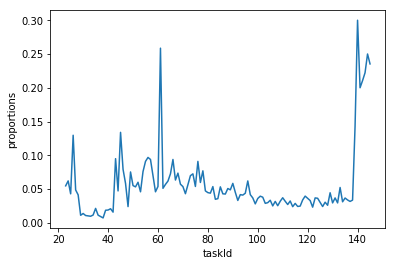

In [388]:
data=metrics[metrics['algorithm'] == 'RandomForestRegressor'][metrics['dataset'] == 'drift'][metrics['runId'] == 1][['duration', 'schedulerDelay', 'proportions']]
sns.lineplot(x='taskId', y='proportions', data=data.reset_index())

In [440]:
data=metrics[metrics['algorithm'] == 'KMeans'][metrics['dataset'] == 'drift'][metrics['runId'] == 1].reset_index(drop=True).copy()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


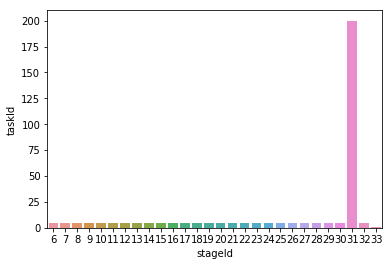

In [441]:
sns.barplot(x='stageId', y='taskId', data=data.groupby(['stageId']).agg({'taskId': 'nunique'}).reset_index())

# Analysis

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from visualization import *
from load import *

metrics = load_metrics('../results/metrics.csv')
metrics = preprocessing_metrics(metrics)

print_audit(perform_audit(metrics, RULES))

metrics.head()

-----------------------------------------------REPORT-----------------------------------------------
+ SUCCESS: train_count_is_greater_than_or_equal_to_test_count
+ SUCCESS: jobs_stages_and_tasks_are_sequential
+ SUCCESS: tasks_are_successful
- FAILURE: all_nodes_are_used
+ SUCCESS: minimum_f1_score_is_respected
- FAILURE: minimum_r2_score_is_respected
+ SUCCESS: minimum_number_of_algorithms_per_family_is_respected
- FAILURE: minimum_number_of_algorithms_per_dataset_is_respected
- FAILURE: minimum_number_of_datasets_per_algorithm_is_respected
+ SUCCESS: number_of_nodes_is_respected
- FAILURE: maximum_number_of_executors_per_node_is_respected
+ SUCCESS: records_written_is_equivalent_to_bytes_written
- FAILURE: records_read_is_equivalent_to_bytes_read
- FAILURE: applicative_time_is_greater_than_or_equal_to_sum_durations_divided_by_number_executors
+ SUCCESS: duration_is_greater_than_or_equal_to_the_sum_of_executor_cpu_deserialize_and_gc_time
+ SUCCESS: tasks_writing_for_shuffle_are_proce

,jobId,jobGroup,stageId,taskId,launchTime,finishTime,duration,schedulerDelay,executorId,host,...,splitter,workflowId,silhouette,f1,weightedPrecision,weightedRecall,accuracy,executorCpuUsage,executorDeserializeCpuUsage,shuffleWriteRate
0,6,NaN,9,38,1554459423102,1554459423181,79,6,5,172.16.96.8,...,none,1,0.107835,NaN,NaN,NaN,NaN,1.000000,0.846154,NaN
1,7,NaN,10,39,1554459423238,1554459423410,172,8,22,172.16.96.45,...,none,1,0.107835,NaN,NaN,NaN,NaN,0.960317,0.868421,1439.0
2,7,NaN,10,40,1554459423240,1554459423406,166,6,13,172.16.96.24,...,none,1,0.107835,NaN,NaN,NaN,NaN,0.948718,0.906977,inf
3,7,NaN,10,41,1554459423240,1554459423399,159,5,20,172.16.96.45,...,none,1,0.107835,NaN,NaN,NaN,NaN,0.962617,0.659574,inf
4,7,NaN,10,42,1554459423240,1554459423353,113,5,5,172.16.96.8,...,none,1,0.107835,NaN,NaN,NaN,NaN,0.962025,0.827586,inf


In [49]:
metrics.columns

Index(['jobId', 'jobGroup', 'stageId', 'taskId', 'launchTime', 'finishTime',
       'duration', 'schedulerDelay', 'executorId', 'host', 'taskLocality',
       'speculative', 'gettingResultTime', 'successful', 'executorRunTime',
       'executorCpuTime', 'executorDeserializeTime',
       'executorDeserializeCpuTime', 'resultSerializationTime', 'jvmGCTime',
       'resultSize', 'numUpdatedBlockStatuses', 'diskBytesSpilled',
       'memoryBytesSpilled', 'peakExecutionMemory', 'recordsRead', 'bytesRead',
       'recordsWritten', 'bytesWritten', 'shuffleFetchWaitTime',
       'shuffleTotalBytesRead', 'shuffleTotalBlocksFetched',
       'shuffleLocalBlocksFetched', 'shuffleRemoteBlocksFetched',
       'shuffleWriteTime', 'shuffleBytesWritten', 'shuffleRecordsWritten',
       'phase', 'experimentId', 'transformTime', 'features', 'fitTime',
       'testCount', 'trainCount', 'mse', 'mae', 'rmse', 'r2', 'algorithm',
       'dataset', 'family', 'platform', 'platformId', 'runId', 'scenarioId',
   

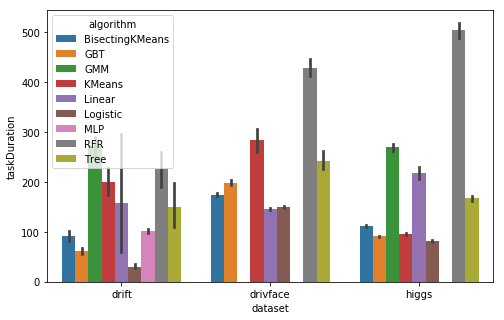

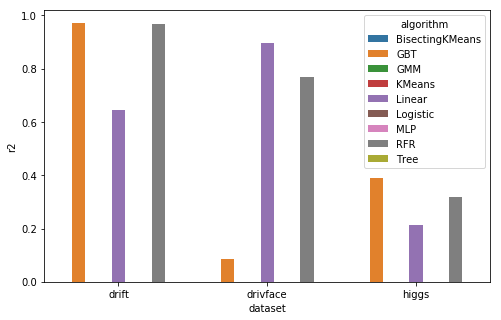

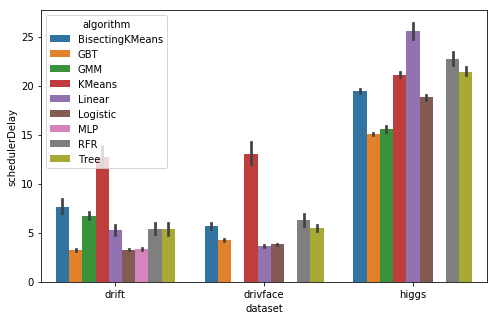

In [91]:
data = metrics.reset_index(drop=True).rename(columns={'duration': 'taskDuration'})
data = data[data['phase'] == 'fit']

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='taskDuration', hue='algorithm', data=data)
plt.savefig('taskDuration.png')

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='r2', hue='algorithm', data=data)
plt.savefig('r2.png')

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='schedulerDelay', hue='algorithm', data=data)
plt.savefig('schedulerDelay.png')

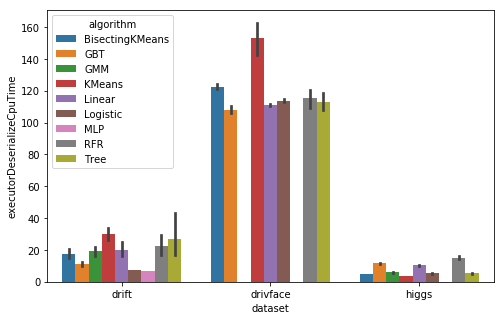

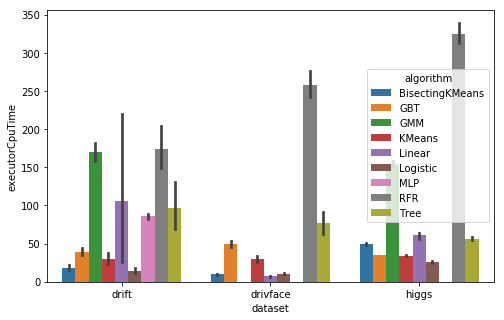

In [92]:
plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='executorDeserializeCpuTime', hue='algorithm', data=data)
plt.savefig('executorDeserializeCpuTime.png')

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='executorCpuTime', hue='algorithm', data=data)
plt.savefig('executorCpuTime.png')

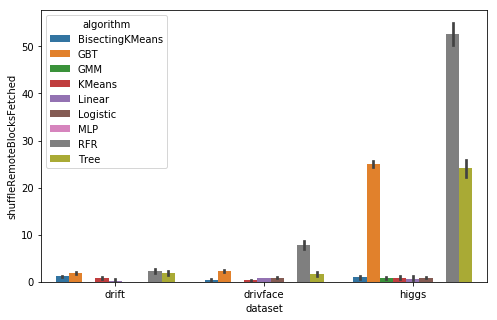

In [93]:
plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='shuffleRemoteBlocksFetched', hue='algorithm', data=data)
plt.savefig('shuffleRemoteBlocksFetched.png')

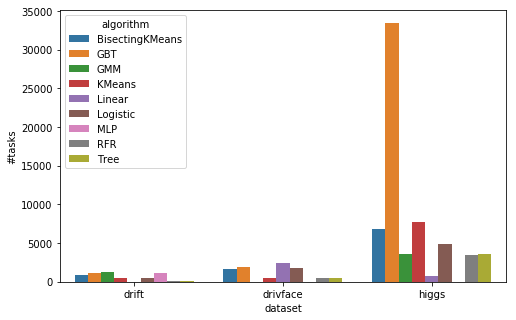

In [94]:
data = metrics.groupby(['dataset', 'algorithm', 'runId']).agg({'taskId': 'count'}).rename(columns={'taskId': '#tasks'})

plt.figure(figsize=(8, 5))
sns.barplot(x='dataset', y='#tasks', hue='algorithm', data=data.reset_index())
plt.savefig('tasks.png')

In [95]:
metrics['phase'] = metrics['phase'].astype('category')
metrics['splitter'] = metrics['splitter'].astype('category')
metrics = metrics.drop(columns='platform')

KeyError: "['platform'] not found in axis"

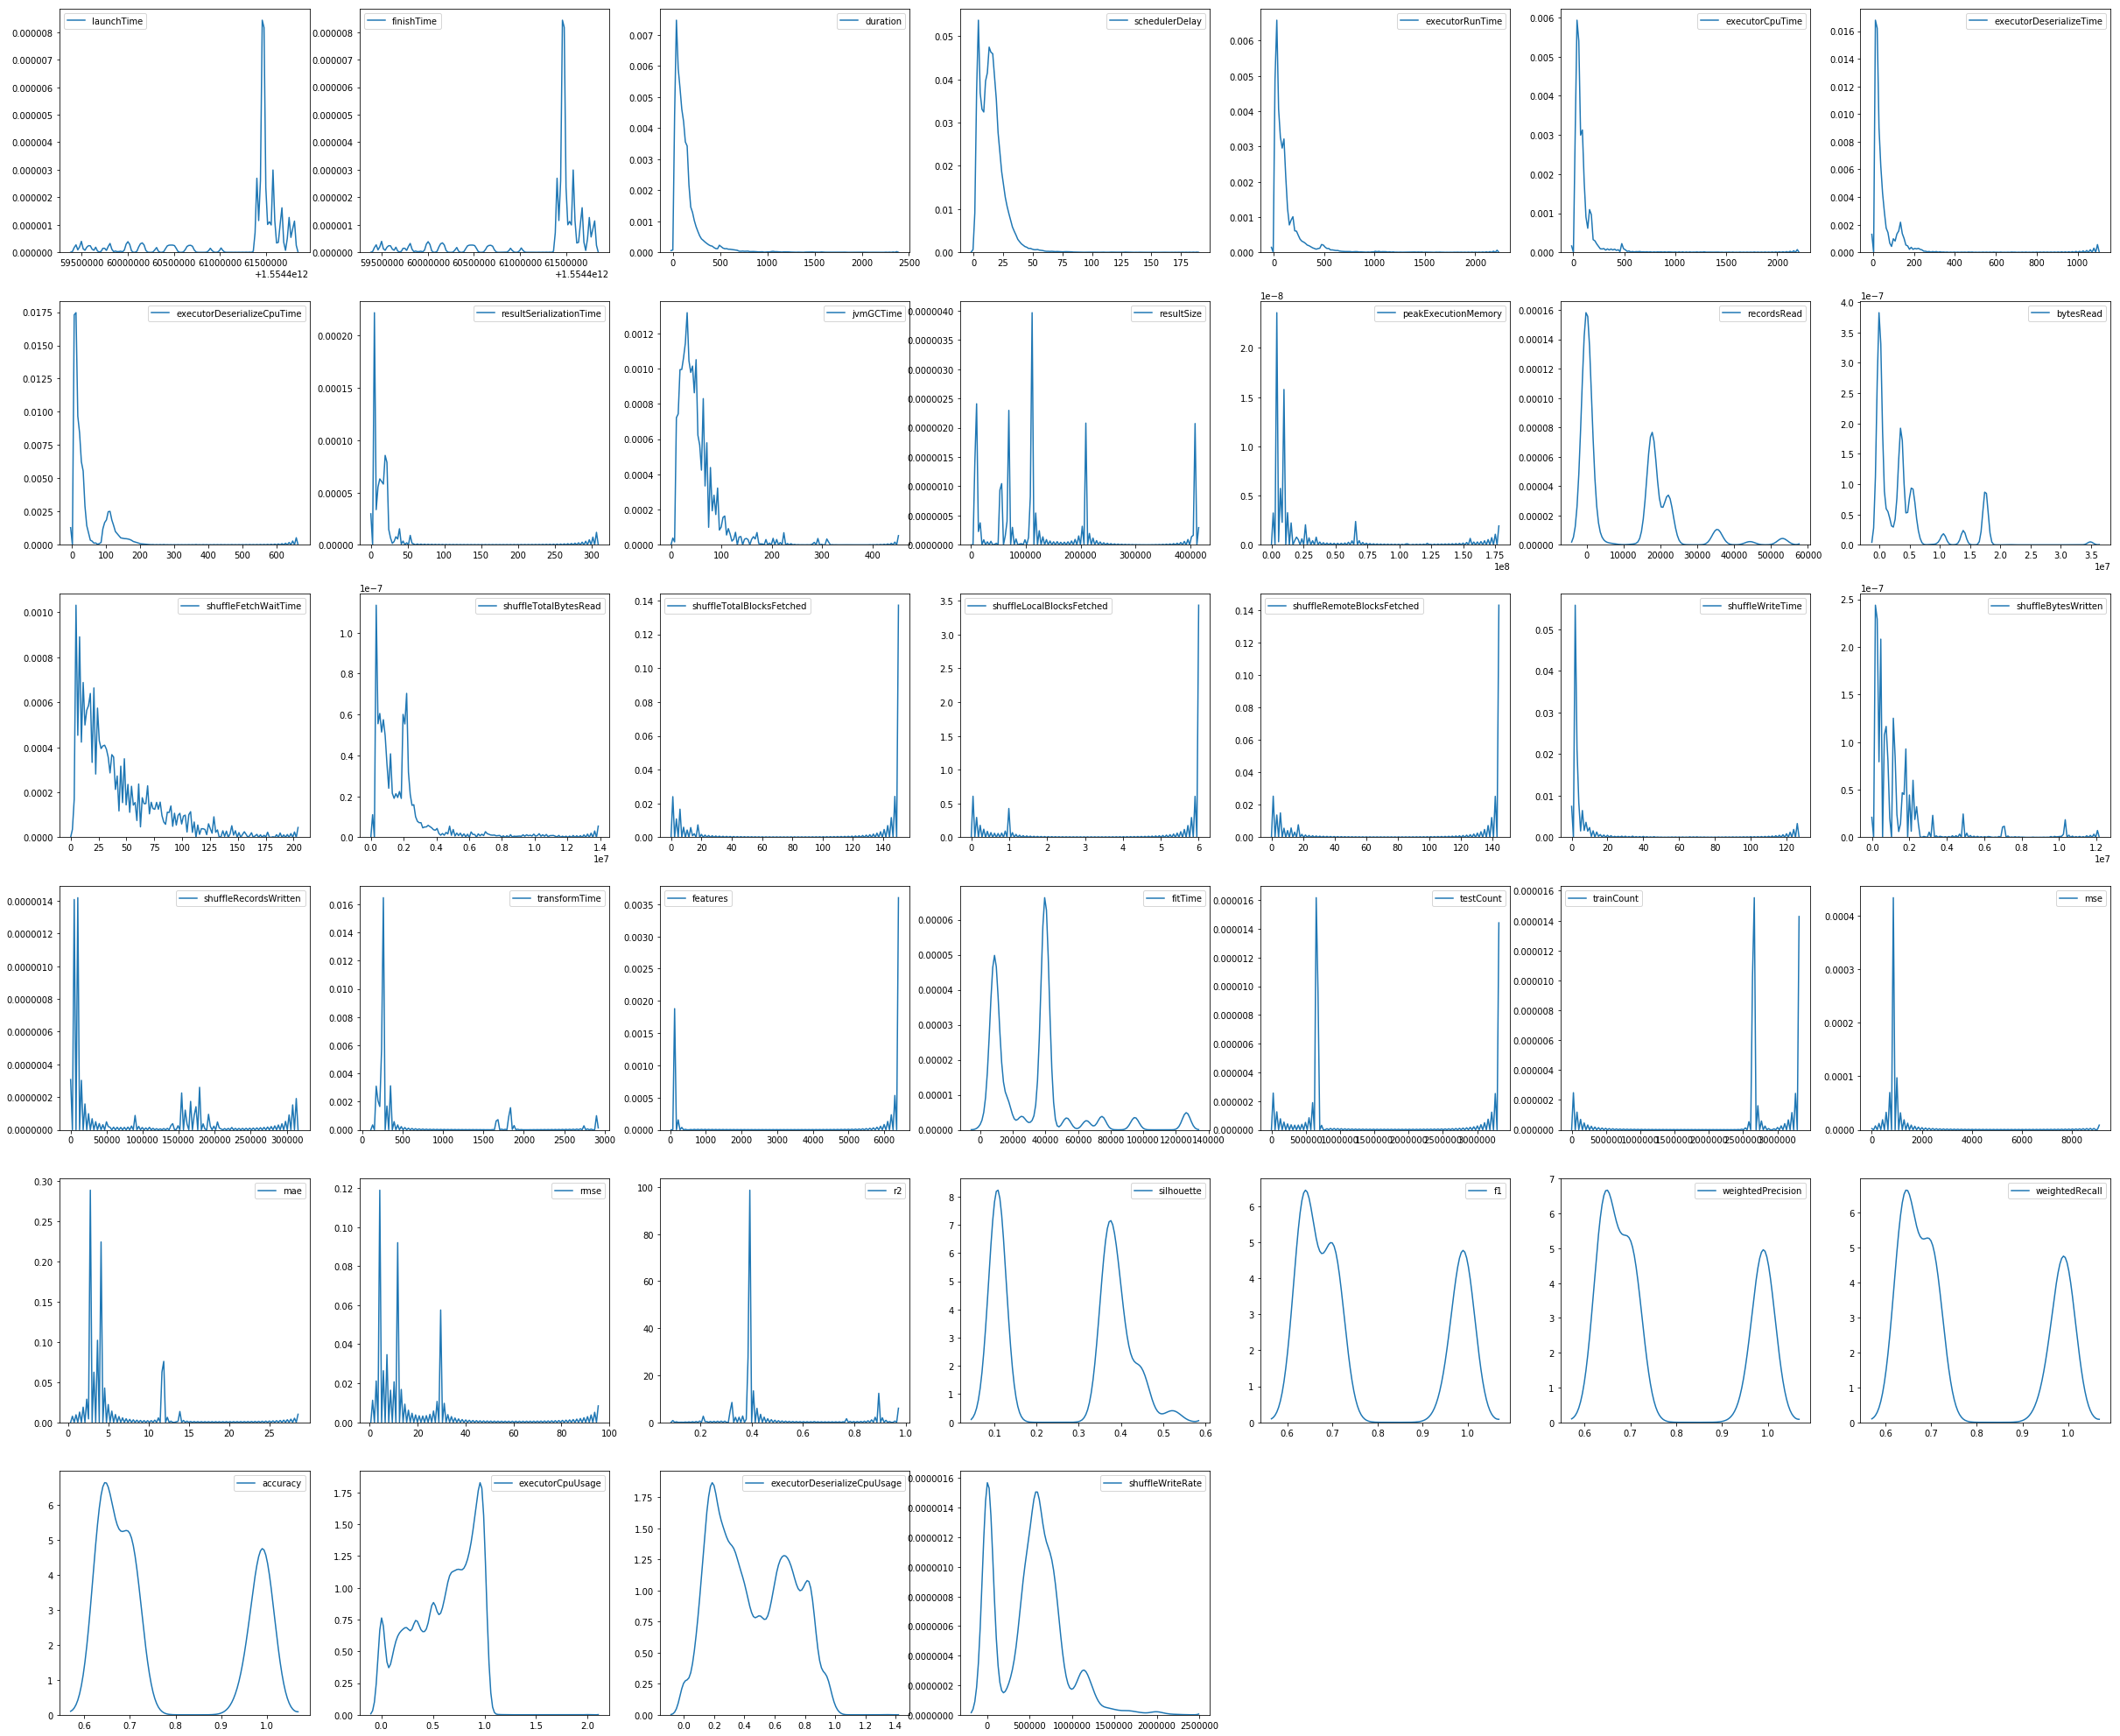

In [104]:
data = metrics.drop(columns=[*metrics.columns[metrics.dtypes == 'category'], *metrics.columns[metrics.columns.str.contains('Id')], *metrics.nunique()[metrics.nunique() <= 1].index])
plot_distributions(data, gridsize=100)

plt.savefig('dists.png')

In [135]:
variable = 'shuffleFetchWaitTime'

data = metrics.reset_index(drop=True).rename(columns={'duration': 'taskDuration'})
data = data.groupby(['dataset', 'algorithm', 'phase'])[variable].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.boxplot(x='dataset', y=variable + 'Ratio', hue='algorithm', data=data)

ValueError: Could not interpret input 'shuffleFetchWaitTimeRatio'

<Figure size 576x360 with 0 Axes>